# FloPy 

### Working stack demo

A short demonstration of some of the `flopy3` awesomeness

In [24]:
%matplotlib inline
from IPython.display import clear_output, display
from __future__ import print_function
import time
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import flopy

###Model Inputs

In [33]:
# first lets load an existing model
model_ws = os.path.join("..","data","freyberg_multilayer_transient")
ml = flopy.modflow.Modflow.load("freyberg.nam", model_ws=model_ws, verbose=False,
                               check=False,exe_name="mfnwt")

In [34]:
ml.dis.sr

xul:619653, yul:3.35328E+06, rotation:15, proj4_str:+proj=utm +zone=14 +ellps=WGS84 +datum=WGS84 +units=m +no_defs

Let's looks at some plots

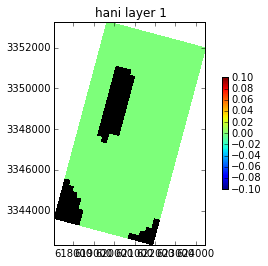

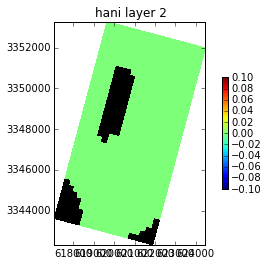

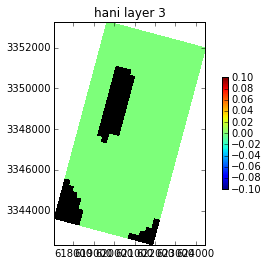

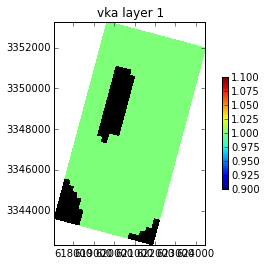

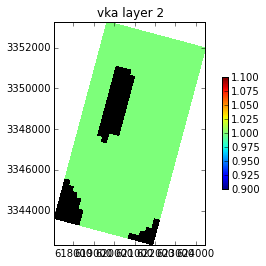

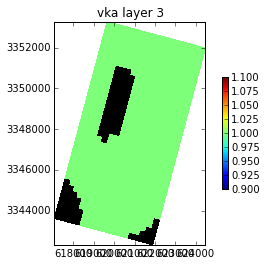

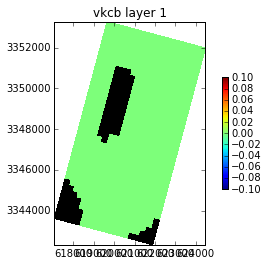

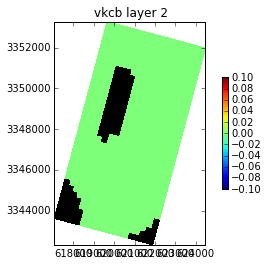

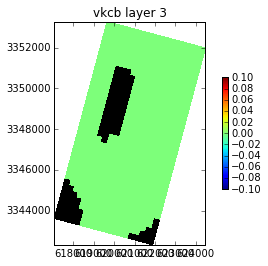

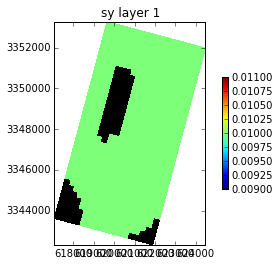

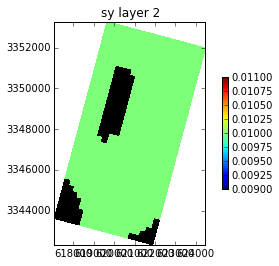

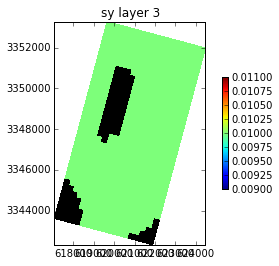

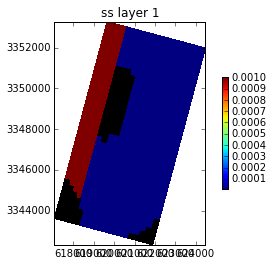

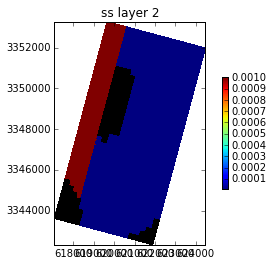

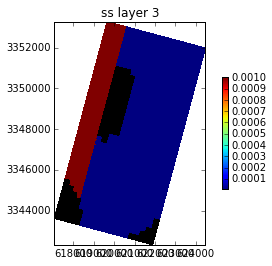

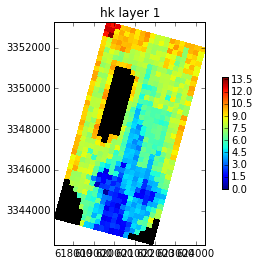

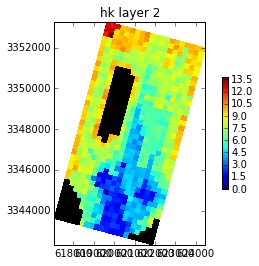

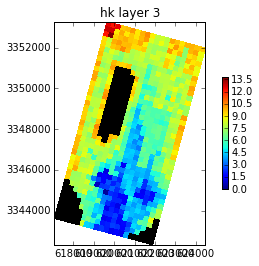

In [35]:
ml.upw.plot()

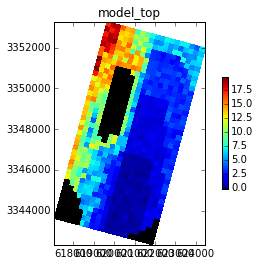

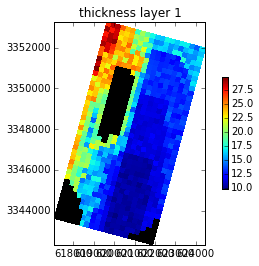

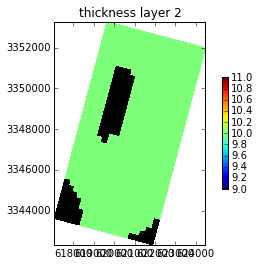

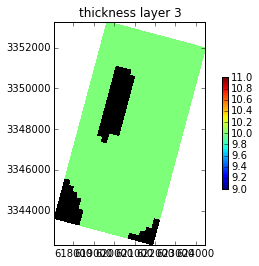

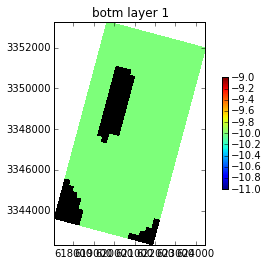

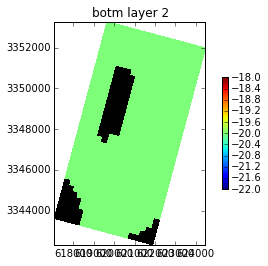

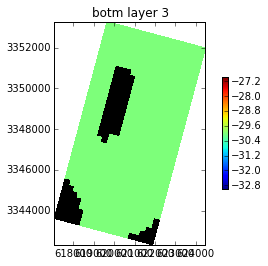

In [36]:
ml.dis.plot()

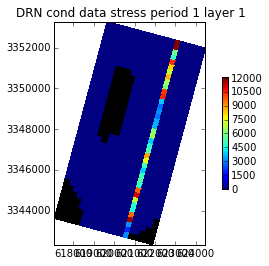

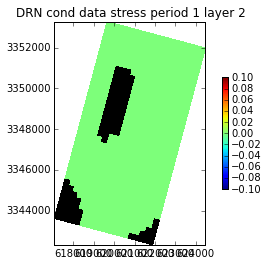

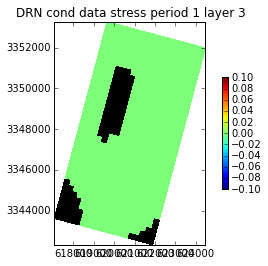

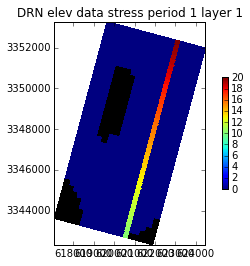

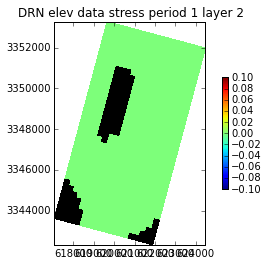

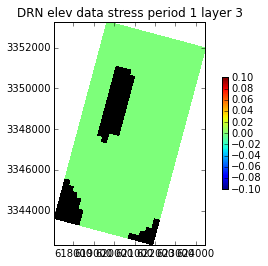

In [37]:
ml.drn.plot(key="cond")
ml.drn.plot(key="elev")


Let's write a shapefile of the DIS package

In [38]:
ml.dis.export(os.path.join(model_ws,"freyberg_dis.shp"))

Let's also write a netCDF file with all model inputs

In [39]:
ml.export(os.path.join(model_ws, "freyberg.nc"))

###Change model directory, modify inputs and write new input files

In [40]:
ml.model_ws = "temp"
print(ml.upw.hk[0].array.mean())
ml.upw.hk[0] *= 2
print(ml.upw.hk[0].array.mean())



changing model workspace...
   temp
5.94751
11.895


### Run the model

In [41]:
ml.write_input()

ml.run_model()
ml

FloPy is using the following executable to run the model: /Users/jwhite/bin/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.0.9 07/01/2014                        
                    BASED ON MODFLOW-2005 Version 1.11.0 08/08/2013                       

                    SWR1 Version 1.03.0 08/30/2013                       

 Using NAME file: freyberg.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2016/03/03 10:00:53

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     4    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     5    Time step:     1    Groundwater-Flow Eqn.
 Solv

MODFLOW 3 layer(s), 40 row(s), 20 column(s), 1097 stress period(s)

### Output inspection

First, let's look at the list file

In [42]:
mfl = flopy.utils.MfListBudget(os.path.join(model_ws,"freyberg.list"))
df_flux, df_vol = mfl.get_dataframes(start_datetime="10-21-2015")
df_flux # multiindex columns

,STORAGE_IN,CONSTANT_HEAD_IN,WELLS_IN,DRAINS,RECHARGE_IN,TOTAL_IN,STORAGE_OUT,CONSTANT_HEAD_OUT,WELLS_OUT,DRAINS_OUT,RECHARGE_OUT,TOTAL_OUT,IN-OUT,PERCENT_DISCREPANCY
2015-10-22,0.000000,0.000000,0,0,6276.861816,6276.861816,0.000000,2446.318848,0.000000,3830.650146,0,6276.968750,-0.106900,-0
2015-10-23,635.447998,0.000000,0,0,6428.198730,7063.646484,31.594000,2430.337891,1302.403198,3299.415039,0,7063.750000,-0.103500,-0
2015-10-24,1361.814941,0.000000,0,0,5397.295898,6759.110840,9.152200,2369.628174,1618.676392,2761.639648,0,6759.096191,0.014648,0
2015-10-25,677.577209,0.000000,0,0,5931.377441,6608.954590,180.233307,2353.585449,1498.694702,2576.461670,0,6608.975586,-0.020996,-0
2015-10-26,697.818298,0.000000,0,0,8378.572266,9076.390625,1051.897461,2417.248291,3119.501953,2487.737305,0,9076.384766,0.005859,0
2015-10-27,429.163086,0.000000,0,0,7390.347656,7819.510742,766.880005,2425.336670,2243.920410,2383.378906,0,7819.516113,-0.005371,-0
2015-10-28,1843.797485,0.000000,0,0,5168.854004,7012.651367,160.420807,2358.079102,2350.731201,2143.399414,0,7012.630859,0.020508,0
2015-10-29,1567.426880,0.000000,0,0,6098.494629,7665.921387,15.289400,2336.975586,3856.392578,1457.258667,0,7665.916504,0.004883,0
2015-10-30,2001.197754,0.000000,0,0,6478.776855,8479.974609,14.397400,2328.516113,5265.850098,871.207214,0,8479.970703,0.003906,0
2015-10-31,2356.429932,0.000000,0,0,5944.929688,8301.359375,578.054321,2272.484131,4830.996582,619.949707,0,8301.484375,-0.125000,-0


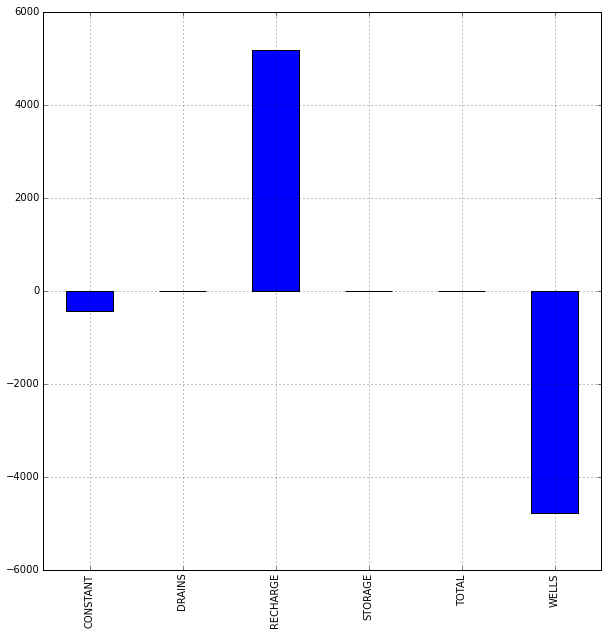

In [43]:
groups = df_flux.groupby(lambda x:x.split('_')[-1],axis=1).groups
df_flux_in = df_flux.loc[:,groups["IN"]]
df_flux_in.columns = df_flux_in.columns.map(lambda x:x.split('_')[0])

df_flux_out = df_flux.loc[:,groups["OUT"]]
df_flux_out.columns = df_flux_out.columns.map(lambda x:x.split('_')[0])


df_flux_delta = df_flux_in - df_flux_out
#df_flux_delta = df_flux.loc[:,"in"] - df_flux.loc[:,"out"]
df_flux_delta.iloc[-1,:].plot(kind="bar",figsize=(10,10),grid=True)

Let's look at head

In [44]:
# if you pass the model instance, then the plots will be offset and rotated
h = flopy.utils.HeadFile(os.path.join(model_ws,"freyberg.hds"),model=ml)
h.times

[1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 32.0,
 33.0,
 34.0,
 35.0,
 36.0,
 37.0,
 38.0,
 39.0,
 40.0,
 41.0,
 42.0,
 43.0,
 44.0,
 45.0,
 46.0,
 47.0,
 48.0,
 49.0,
 50.0,
 51.0,
 52.0,
 53.0,
 54.0,
 55.0,
 56.0,
 57.0,
 58.0,
 59.0,
 60.0,
 61.0,
 62.0,
 63.0,
 64.0,
 65.0,
 66.0,
 67.0,
 68.0,
 69.0,
 70.0,
 71.0,
 72.0,
 73.0,
 74.0,
 75.0,
 76.0,
 77.0,
 78.0,
 79.0,
 80.0,
 81.0,
 82.0,
 83.0,
 84.0,
 85.0,
 86.0,
 87.0,
 88.0,
 89.0,
 90.0,
 91.0,
 92.0,
 93.0,
 94.0,
 95.0,
 96.0,
 97.0,
 98.0,
 99.0,
 100.0,
 101.0,
 102.0,
 103.0,
 104.0,
 105.0,
 106.0,
 107.0,
 108.0,
 109.0,
 110.0,
 111.0,
 112.0,
 113.0,
 114.0,
 115.0,
 116.0,
 117.0,
 118.0,
 119.0,
 120.0,
 121.0,
 122.0,
 123.0,
 124.0,
 125.0,
 126.0,
 127.0,
 128.0,
 129.0,
 130.0,
 131.0,
 132.0,
 133.0,
 134.0,
 135.0,
 136.0,
 137.0,
 138.0,
 139

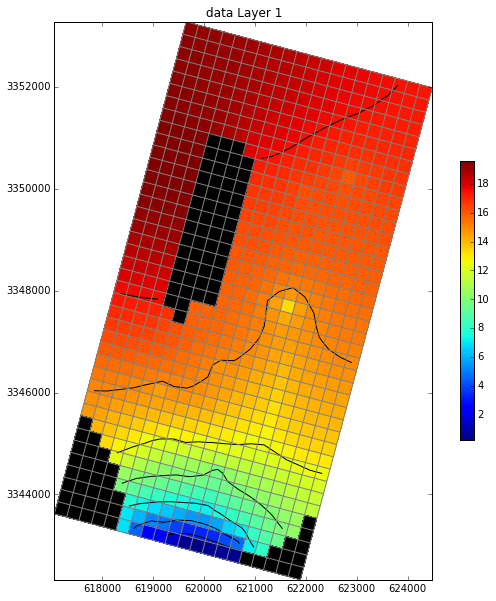

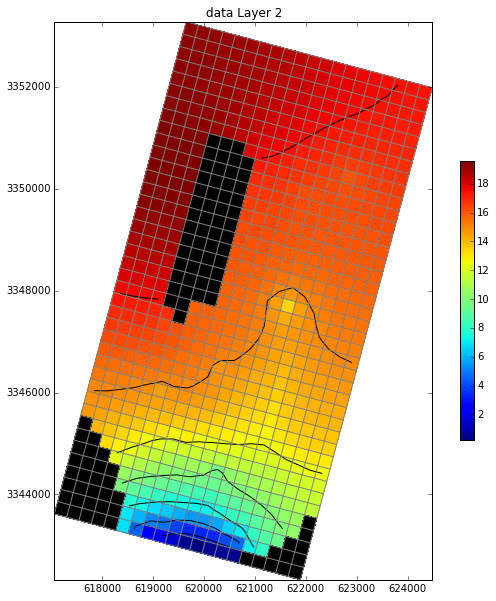

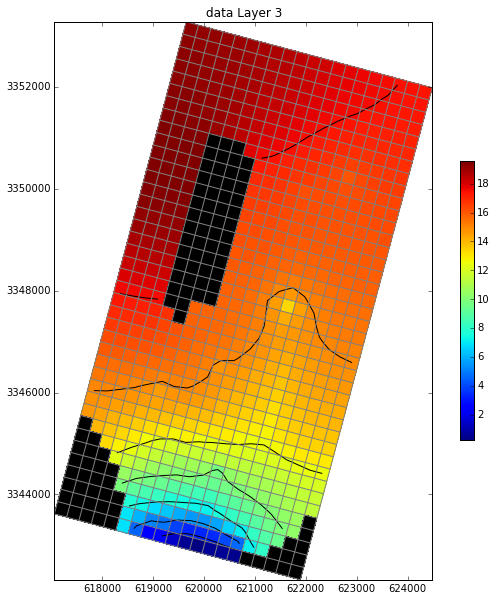

In [45]:
h.plot(totim=900,contour=True,grid=True,colorbar=True,figsize=(10,10))

In [46]:
#let's write these heads to shapefile
h.to_shapefile(os.path.join(model_ws,"freyburg_head.shp"))

### Let's make an outputs movie

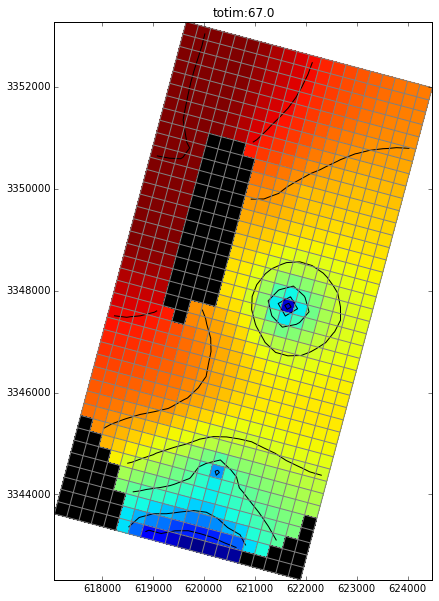

In [ ]:
f = plt.figure(figsize=(10,10))
ax = plt.subplot(1,1,1,aspect="equal")
for i,t in enumerate(h.times):
    ax.set_title("totim:{0}".format(t))
    h.plot(totim=t,mflay=0,contour=True,
           grid=True,figsize=(10,10),
            vmin=0,vmax=20,axes=[ax])
    time.sleep(0.01)
    clear_output(True)
    display(f)
    ax.cla()